# Set Environment & Globals


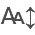

/mnt/DATA/home/ethung/spatial_seq/.venv/lib/python3.12/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)
/mnt/DATA/home/ethung/spatial_seq/.venv/lib/python3.12/site-packages/phenograph/cluster.py:13: DeprecationWarning: Please import `spmatrix` from the `scipy.sparse` namespace; the `scipy.sparse.base` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.sparse.base import spmatrix


In [1]:
%load_ext jupyter_black

# base
import os
import sys
import warnings
import logging

logging.basicConfig(level="WARNING")
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import itables

itables.init_notebook_mode(all_interactive=True)

warnings.simplefilter("ignore", pd.errors.DtypeWarning)
mlogger = logging.getLogger("matplotlib")
mlogger.setLevel(logging.WARNING)

# single cell
import scanpy as sc
import spatialdata as sd
import spatialdata_plot as sdp
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent

# custom
from single_cell.R import *
from single_cell.preprocess import *
from single_cell.plot import *
from single_cell.analysis import *
from spatial_seq.plot import *
from utils import *

# R
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter

converter = get_converter()
%load_ext rpy2.ipython

In [6]:
# analysis & device specific
%matplotlib inline
CORES = 10
DATADIR = "../../../data"
REFDIR = "../../../references"

# Load data

In [ ]:
# LOAD
sdata = sd.read_zarr(
    os.path.join(DATADIR, "processed", "spatial", "raws", "COMBINED_RAW")
)
samples = list(sdata["square_008um"].obs["Identifier"].unique())

annotation = "raw_processed-V5 WT_filter70"
adata_sp = sc.read_h5ad(
    os.path.join(DATADIR, "processed", "spatial", "combined", f"{annotation}.h5ad")
)
aucell = sc.read_h5ad(
    os.path.join(
        DATADIR, "processed", "spatial", "combined", f"{annotation} AUCELL.h5ad"
    )
)

# Exploratory Analysis

### Cluster

In [ ]:
%%time
from sklearn.metrics import silhouette_score

for res in [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
    res = 1
    cluster_key = f"leiden_{res:.1f}"
    print(cluster_key)
    sc.tl.leiden(adata_sp, resolution=res, key_added=cluster_key)

In [ ]:
%%time
res = 1.5
cluster_key = f"leiden_{res:.1f}"

f, axs = plt.subplots(
    1, len(samples), figsize=(len(samples) * 6, 6), layout="constrained"
)
for n, id in enumerate(adata_sp.obs["Identifier"].unique()):
    sc.pl.spatial(
        adata_sp[adata_sp.obs["Identifier"] == id],
        color=cluster_key,
        spot_size=150 if n == 0 else 200,
        ax=axs[n],
        show=False,
        palette=color_gen(adata_sp.obs[cluster_key].unique()).to_list(),
        title=id,
    )

CPU times: user 103 μs, sys: 0 ns, total: 103 μs
Wall time: 144 μs


NameError: name 'samples' is not defined

In [ ]:
# SAVE
adata_sp.write(
    os.path.join(DATADIR, "processed", "combined", "raw_processed-V5 WT_filter70.h5ad")
)

In [ ]:
# LOAD
adata_sp = sc.read_h5ad(
    os.path.join(DATADIR, "processed", "combined", "raw_processed-V5 WT_filter70.h5ad")
)

### Visualize

In [ ]:
res = 1.5
cluster_key = f"leiden_{res:.1f}"
embedding = "UMAP"

cluster_c = color_gen(adata_sp.obs[cluster_key])
f = plt.figure(figsize=(10, 10), layout="constrained")

axs = f.subplots(3, 2)
gs = axs[0, 0].get_gridspec()
for rs in axs[:]:
    for ax in rs[:]:
        ax.remove()

# Large plot
ax = f.add_subplot(gs[:2, :])
sc.pl.embedding(
    adata_sp,
    basis=embedding,
    color=[cluster_key],
    ax=ax,
    show=False,
    legend_loc="on data",
    legend_fontoutline=2,
    legend_fontsize=20,
    palette=cluster_c.to_list(),
)
# ax = f.add_subplot(gs[2, 0])
# sc.pl.embedding(
#     adata_sp,
#     basis=embedding,
#     color=["Group"],
#     ax=ax,
#     show=False,
#     alpha=0.7,
# )
ax = f.add_subplot(gs[2, 0])
sc.pl.embedding(
    adata_sp, basis=embedding, color=["Diet"], ax=ax, show=False, alpha=0.7
)
ax = f.add_subplot(gs[2, 1])
sc.pl.embedding(
    adata_sp, basis=embedding, color=["Model"], ax=ax, show=False, alpha=0.7
)

In [ ]:
variable_genes = (
    adata_sp.var[adata_sp.var["highly_variable"]].sort_values(
        "highly_variable_rank"
    )
).index
variable_genes

In [ ]:
def plot_violinplot(
    adata,
    markers,
    group: str,
    f,
    layer: str = "normalized",
    useStripPlot=True,
    bracket_params=None,
):
    axs = f.subplots(len(markers), 1)
    for n, m in enumerate(markers):
        sc.pl.violin(
            adata,
            m,
            groupby=group,
            use_raw=False,
            layer=layer,
            show=False,
            ax=axs[n],
            stripplot=useStripPlot,
        )
        if n < len(markers) - 1:
            axs[n].set_xlabel("")
            axs[n].set_xticklabels([""] * len(axs[n].get_xticklabels()))
        axs[n].set_ylabel(axs[n].get_ylabel(), size=12)

    if bracket_params is not None:
        ratios = bracket_params["ratio"] / np.sum(bracket_params["ratio"])
        ends = np.append(0, np.cumsum(ratios))
        bar_label_locs = [ends[i] + ratios[i] / 2 for i in range(len(ratios))]
        bar_bracket_widths = ratios * f.get_size_inches()[0] * 3.1

        axs = f.get_axes()
        for (
            n,
            label,
        ) in enumerate(bracket_params["labels"]):
            axs[-1].annotate(
                label,
                xy=(bar_label_locs[n], -bracket_params["bracket_y"]),
                xytext=(bar_label_locs[n], -bracket_params["label_y"]),
                xycoords="axes fraction",
                ha="center",
                va="bottom",
                bbox=dict(boxstyle="square", fc="none", color="none"),
                arrowprops=dict(
                    arrowstyle=f"-[, widthB={bar_bracket_widths[n]}, lengthB=0.3",
                    lw=1.0,
                    color="k",
                ),
            )
        axs[-1].set_xlabel(axs[-1].get_xlabel(), labelpad=bracket_params["padding"])

    return


f = plt.figure(figsize=(10, 15), layout="constrained")

# markers = [
#     "Adipoq",
#     "Pdgfra",
#     "Upk3b",
#     "Cdh5",
#     "Rgs5",
#     "Adgre1",
#     "Flt3",
#     "Cpa3",
#     "Skap1",
#     "Igkc",
# ]
plot_violinplot(
    adata_sp,
    variable_genes[:20],
    cluster_key,
    f,
    useStripPlot=False,
    layer="normalized",
)

In [ ]:
res = 1.5
cluster_key = f"leiden_{res:.1f}"

sc.tl.rank_genes_groups(
    adata_sp,
    groupby=cluster_key,
    groups=["0"],
    reference=["3"],
    key_added=f"de_temp_0_3",
    use_raw=False,
    layer="normalized",
    method="wilcoxon",
)
df = sc.get.rank_genes_groups_df(adata_sp, group=None, key=f"de_temp_0_3")

In [ ]:
df = df[df.pvals_adj < 0.05]
df[df.group == "3"]

group  names     scores  logfoldchanges          pvals      pvals_adj
12866     3  Fabp4  86.401443        2.174710   0.000000e+00   0.000000e+00
12867     3   Apoe  35.430698        0.714446  5.752126e-275  3.700343e-271
12868     3   Scd1  32.998360        1.000099  8.574932e-239  3.677503e-235
12869     3   Car3  28.771622        0.919045  4.859704e-182  1.563124e-178
12870     3     Hp  25.252420        1.055359  1.065318e-140  2.741275e-137
...     ...    ...        ...             ...            ...            ...
25727     3   Lyz2  -9.251806       -0.513568   2.207297e-20   1.774942e-17
25728     3  Timp2  -9.817713       -0.691059   9.446279e-23   9.348909e-20
25729     3    Fn1 -10.349426       -1.174527   4.210015e-25   4.924187e-22
25730     3     C3 -10.959126       -0.406044   6.007736e-28   8.588393e-25
25731     3    Dcn -17.948706       -1.170011   4.912187e-72   9.028601e-69

[99 rows x 6 columns]

dendrogram data not found (using key=dendrogram_leiden_1.5). Running `sc.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `sc.tl.dendrogram` independently.


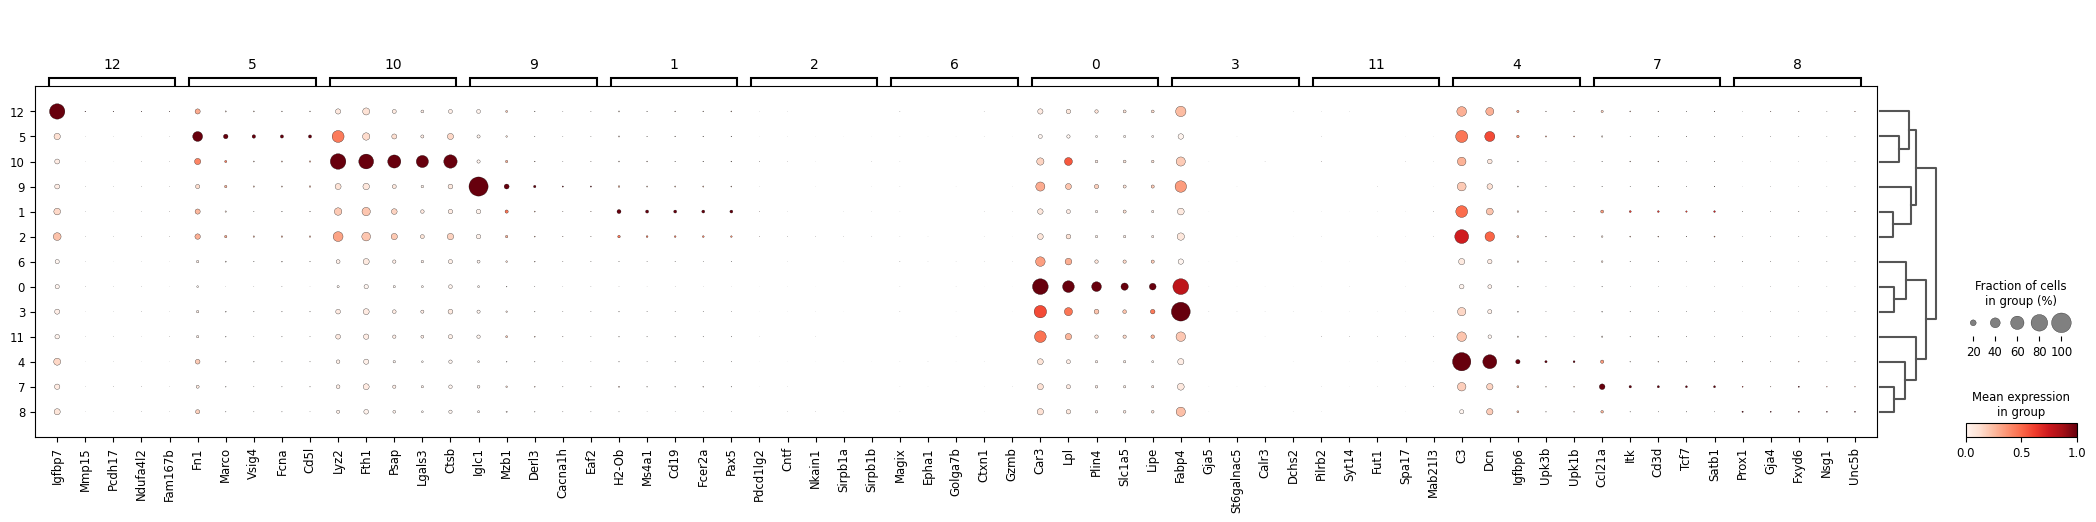

In [ ]:
res = 1.5
cluster_key = f"leiden_{res:.1f}"

sc.tl.rank_genes_groups(
    adata_sp,
    groupby=cluster_key,
    key_added=f"de_{cluster_key}",
    use_raw=False,
    layer="normalized",
    method="wilcoxon",
)

sc.pl.rank_genes_groups_dotplot(
    adata_sp,
    groupby=cluster_key,
    key=f"de_{cluster_key}",
    standard_scale="var",
    n_genes=5,
    min_logfoldchange=2,
)

group  names     scores  logfoldchanges         pvals     pvals_adj
0          0   Car3  84.449402        2.234160  0.000000e+00  0.000000e+00
1          0  Fabp4  76.385910        1.858742  0.000000e+00  0.000000e+00
2          0   Scd1  64.170952        1.727922  0.000000e+00  0.000000e+00
3          0    Cfd  58.045467        1.899414  0.000000e+00  0.000000e+00
4          0    Lpl  55.556240        2.116733  0.000000e+00  0.000000e+00
...      ...    ...        ...             ...           ...           ...
167253    12    Gsn  -4.111439       -0.650103  3.932003e-05  3.891473e-02
167254    12    Lpl  -5.714816       -0.931540  1.098227e-08  1.412979e-05
167255    12    Cfd  -6.539968       -0.886784  6.153184e-11  8.796318e-08
167256    12   Car3 -12.168492       -1.554703  4.574525e-34  9.809307e-31
167257    12   Scd1 -14.115847       -1.636182  3.033508e-45  9.757277e-42

[254 rows x 6 columns]

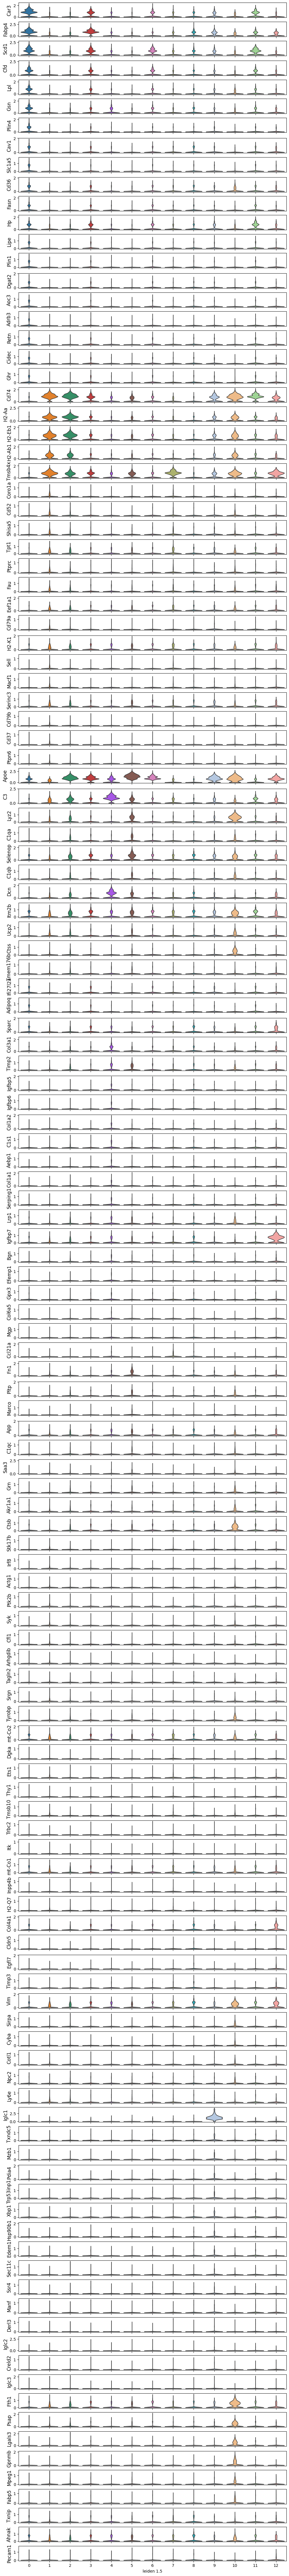

In [ ]:
res = 1.5
cluster_key = f"leiden_{res:.1f}"

df = sc.get.rank_genes_groups_df(adata_sp, group=None, key=f"de_{cluster_key}")
# threshold = 1e-75
# DEGs_cutoff = df[df["pvals_adj"] < threshold].names.unique()
# print("DEGs under threshold:", len(DEGs_cutoff))

cutoff = 20
topDEGs_df = pd.concat(
    [
        tmp[tmp.pvals_adj < 0.05].nlargest(cutoff, "scores")
        for _, tmp in df.groupby("group")
    ]
)

topDEGs = topDEGs_df.names.unique()

f = plt.figure(figsize=(10, 90), layout="constrained")
plot_violinplot(
    adata_sp,
    topDEGs,
    cluster_key,
    f,
    useStripPlot=False,
    layer="normalized",
)

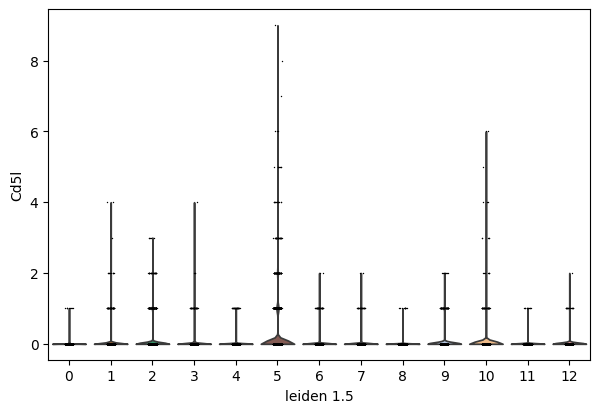

In [ ]:
sc.pl.violin(adata_sp, keys="Cd5l", groupby="leiden_1.5")

In [ ]:
cutoff = 50
topDEGs_df = pd.concat(
    [
        tmp[tmp.pvals_adj < 0.05].nlargest(cutoff, "scores")
        for _, tmp in df.groupby("group")
    ]
)

topDEGs_df[topDEGs_df["group"] == "12"]

group   names     scores  logfoldchanges          pvals      pvals_adj
154392    12  Igfbp7  35.176521        2.602688  4.570921e-271  5.880946e-267
154393    12  Col4a1  15.126262        1.601657   1.086979e-51   6.992535e-48
154394    12  Tmsb4x  14.721337        0.728235   4.702698e-49   2.016830e-45
154395    12     Vim  13.306617        0.976463   2.118588e-40   5.451550e-37
154396    12   Sparc  11.479462        1.050470   1.673194e-30   3.075330e-27
154397    12    Apoe  10.680469        0.443524   1.256353e-26   2.020530e-23
154398    12   Egfl7   4.768310        1.329285   1.857777e-06   2.172923e-03
154399    12  Pecam1   4.469821        1.217123   7.828484e-06   8.393440e-03
154400    12   Timp3   4.038284        0.901317   5.384360e-05   4.948227e-02
167253    12     Gsn  -4.111439       -0.650103   3.932003e-05   3.891473e-02
167254    12     Lpl  -5.714816       -0.931540   1.098227e-08   1.412979e-05
167255    12     Cfd  -6.539968       -0.886784   6.153184e-11   8.796318e-08
167256    12    Car3 -12.168492       -1.554703   4.574525e-34   9.809307e-31
167257    12    Scd1 -14.115847       -1.636182   3.033508e-45   9.757277e-42

### AUCell for bin assignment

#### Run AUCell

In [ ]:
# Setup
ref_dir = os.path.join(REFDIR, "custom_signatures")

collections = {
    "snRNA_SoEtAl_immuneVstromal": pd.read_csv(
        os.path.join(ref_dir, "snRNA_SoEtAl2025_DEGS-stromal_VS_immune_markers.csv"),
        index_col=0,
    ).rename(columns={"group": "source", "names": "target"}),
    "snRNA_SoEtAl_immune": pd.read_csv(
        os.path.join(ref_dir, "snRNA_SoEtAl2025_DEGS-immune_markers.csv"),
        index_col=0,
    ).rename(columns={"group": "source", "names": "target"}),
    "snRNA_SoEtAl_stromal": pd.read_csv(
        os.path.join(ref_dir, "snRNA_SoEtAl2025_DEGS-stromal_markers.csv"),
        index_col=0,
    ).rename(columns={"group": "source", "names": "target"}),
}

In [ ]:
for name, geneset in collections.items():
    GSEA_decoupler(
        adata_sp, name, type="AUCell", geneset=geneset, remove_prefix=False
    )
adata_sp.obsm["snRNA_SoEtAl_stromal_score_aucell"].rename(
    columns={"PC/SMC": "PC-SMC"}, inplace=True
)

adata_sp

In [ ]:
res = 1.5
cluster_key = f"leiden_{res:.1f}"

scores = []
for name, geneset in collections.items():
    score = dc.pp.get_obsm(adata=adata_sp, key=f"{name}_score_aucell")
    sc.pl.embedding(
        score,
        basis="UMAP",
        color=list(geneset.source.unique()) + [cluster_key],
        cmap="Reds",
        # vmax=0.15,
        ncols=2,
        legend_loc="on data",
    )
    scores.append(score)


# f = plt.figure(figsize=(len(collections) * 5, 10), layout="constrained")
# ax = f.subplots(2, len(collections)).flatten()

# for i, cond in enumerate(score.obs["Condition"].unique()):
#     tmp = score[score.obs["Condition"] == cond]
#     for j, coll in enumerate(collections):
#         sc.pl.embedding(
#             tmp,
#             basis="LocalMAP_fibro",
#             color=coll,
#             title=f"{coll}\n({cond} eWAT)",
#             vmax=np.max(score[:, coll].X),
#             ax=ax[i * len(collections) + j],
#             show=False,
#         )

#### Plot

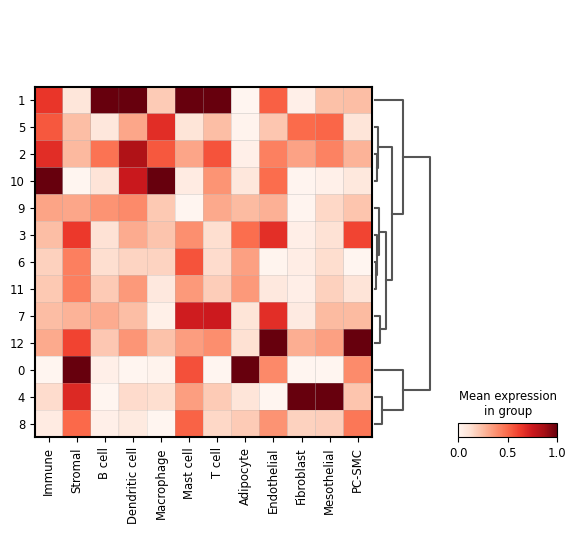

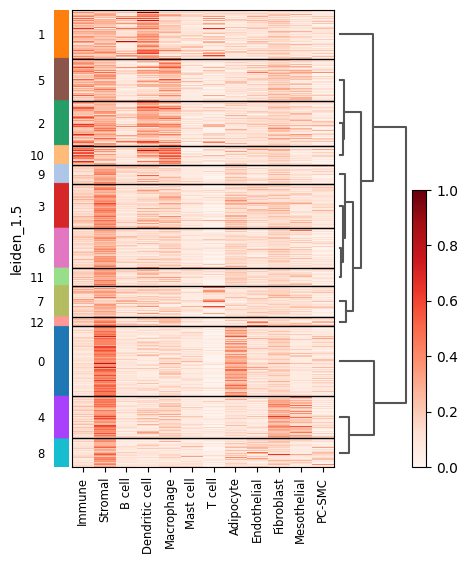

In [ ]:
aucell_sets = [
    dc.pp.get_obsm(adata=adata_sp, key=f"{name}_score_aucell").var_names
    for name, _ in collections.items()
]
aucell_sets = aucell_sets[0].append(aucell_sets[1:])

# aucell = sc.AnnData(
#     X=np.hstack([score.X for score in scores]),
#     obs=score.obs,
#     var=pd.DataFrame(index=aucell_sets),
#     obsm=score.obsm,
# )

sc.pl.matrixplot(
    aucell,
    var_names=aucell_sets,
    groupby=cluster_key,
    dendrogram=True,
    cmap="Reds",
    # vmax=0.15,
    standard_scale="var",
)

sc.pl.heatmap(
    aucell,
    var_names=aucell_sets,
    groupby=cluster_key,
    dendrogram=True,
    cmap="Reds",
    # vmax=0.15,
    standard_scale="var",
)

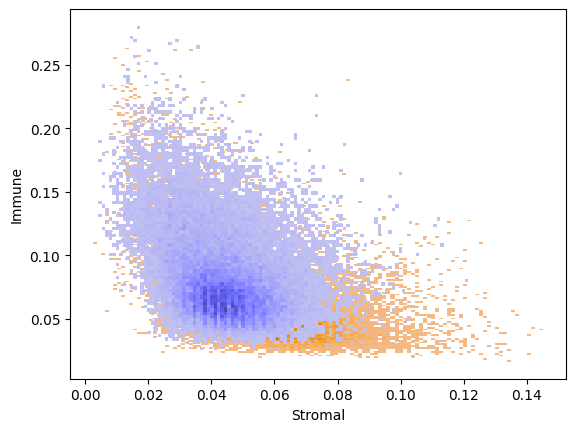

In [ ]:
groups = [0, 4, 8, 12, 3, 6]
cat1 = "Stromal"
cat2 = "Immune"
cluster_key = "leiden_1.0"

# sns.histplot(aucell.to_df()[category])

sns.histplot(
    aucell[aucell.obs[cluster_key].isin(pd.Series(groups).astype(str))].to_df(),
    x=cat1,
    y=cat2,
    alpha=1,
    label=f"Stromal",
    color="orange",
)

sns.histplot(
    aucell[~aucell.obs[cluster_key].isin(pd.Series(groups).astype(str))].to_df(),
    x=cat1,
    y=cat2,
    alpha=1,
    label=f"Immune",
    color="blue",
)
plt.legend()

In [ ]:
aucell_df = aucell.to_df()
aucell_df["leiden_1.5"] = aucell.obs["leiden_1.5"].copy()
aucell_df = aucell_df.groupby("leiden_1.5").mean()
aucell_df[:] = scipy.stats.rankdata(aucell_df.groupby("leiden_1.5").mean(), axis=0)
aucell_df

Immune  Stromal  B cell  Dendritic cell  Macrophage  Mast cell  \
leiden_1.5                                                                   
0              1.0     13.0     2.0             1.0         2.0       11.0   
1             11.0      2.0    13.0            13.0         7.0       13.0   
2             12.0      4.0    12.0            12.0        11.0        4.0   
3              6.0     11.0     6.0             6.0         9.0        8.0   
4              3.0     12.0     1.0             3.0         5.0        5.0   
5             10.0      3.0     4.0             7.0        12.0        3.0   
6              4.0      8.0     7.0             4.0         6.0       10.0   
7              7.0      5.0    10.0             5.0         3.0       12.0   
8              2.0      9.0     3.0             2.0         1.0        9.0   
9              9.0      6.0    11.0            10.0         8.0        1.0   
10            13.0      1.0     5.0            11.0        13.0        2.0   
11             5.0      7.0     8.0             8.0         4.0        7.0   
12             8.0     10.0     9.0             9.0        10.0        6.0   

            T cell  Adipocyte  Endothelial  Fibroblast  Mesothelial  PC-SMC  
leiden_1.5                                                                   
0              1.0       13.0          7.0         1.0          1.0    10.0  
1             13.0        1.0         10.0         4.0          8.0     7.0  
2             11.0        3.0          8.0        11.0         11.0     9.0  
3              2.0       12.0         11.0         6.0          3.0    12.0  
4              6.0        5.0          1.0        13.0         13.0     6.0  
5              7.0        2.0          4.0        12.0         12.0     3.0  
6              3.0       10.0          2.0         7.0          4.0     1.0  
7             12.0        6.0         12.0         8.0          9.0     8.0  
8              4.0        8.0          6.0         9.0          7.0    11.0  
9              8.0        9.0          5.0         2.0          5.0     5.0  
10             9.0        4.0          9.0         3.0          2.0     2.0  
11             5.0       11.0          3.0         5.0          6.0     4.0  
12            10.0        7.0         13.0        10.0         10.0    13.0

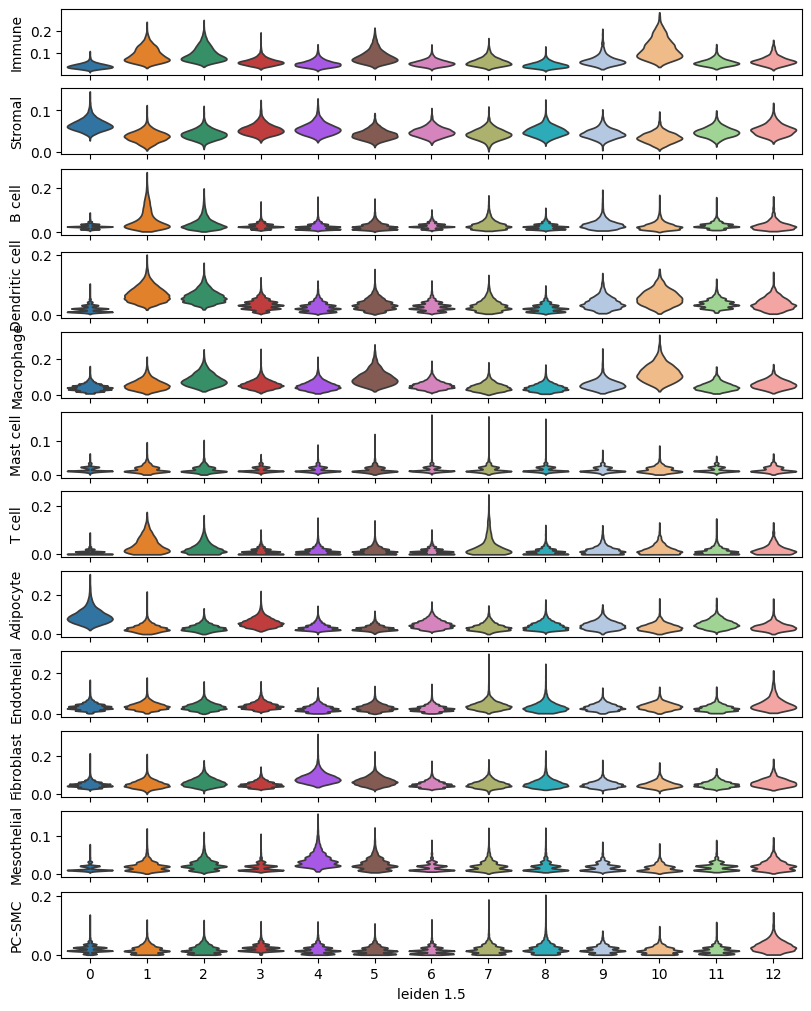

In [ ]:
f = plt.figure(figsize=(8, 10), layout="constrained")
plot_violinplot(
    aucell,
    aucell.var_names,
    "leiden_1.5",
    f,
    layer=None,
    useStripPlot=False,
    ylabel_size=10,
)

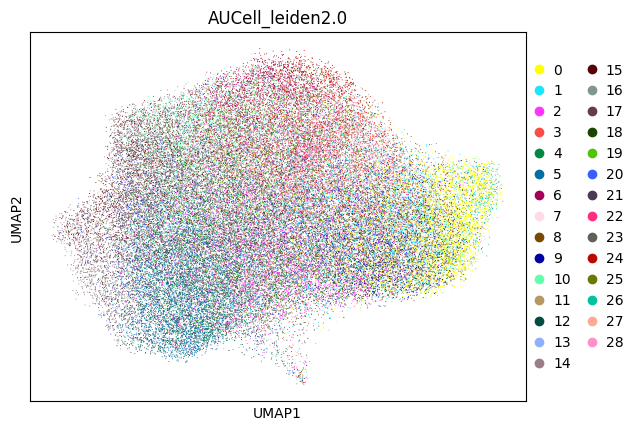

In [ ]:
# cell type assignment via AUCell?
key = "_AUCell"
neighbor_key = "aucell_neighbors"
res = 2
cluster_key = f"AUCell_leiden{res:.1f}"

runDR = False
runClust = False

if runDR is True:
    Visualize(aucell, key, None, neighbor_key)

if runClust is True:
    print("Starting clustering...")
    sc.tl.leiden(
        aucell, resolution=res, key_added=cluster_key, neighbors_key=neighbor_key
    )
    aucell.layers["original"] = aucell.X.copy()

# Plot
sc.pl.embedding(
    aucell,
    basis="UMAP",
    color=cluster_key,
)

In [ ]:
f = plt.figure(figsize=(10, 20), layout="constrained")
plot_violinplot(aucell, aucell.var_names, "AUCell_clusters", f, layer="original")

INFO     Rasterizing image for faster rendering.                                                                   


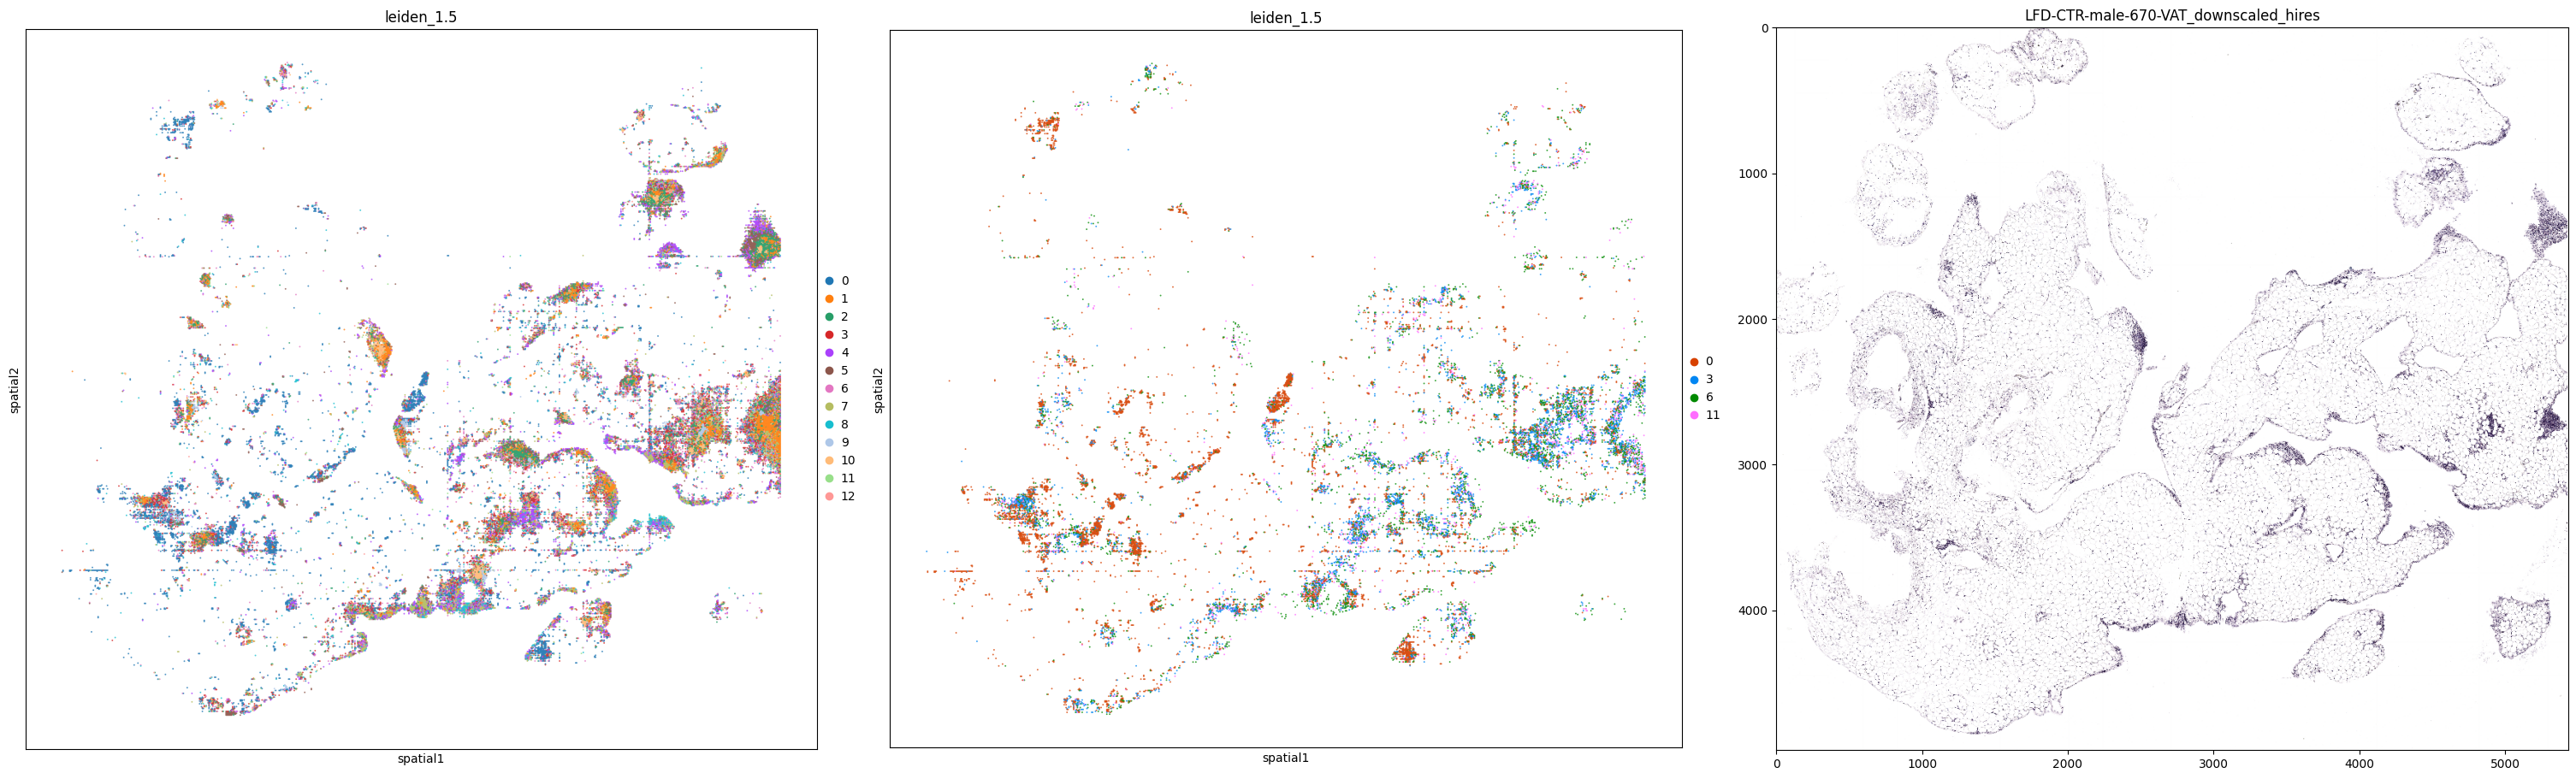

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(30, 10), layout="constrained")
sample1 = aucell[aucell.obs["Identifier"] == samples[0]]
sample1_macs = sample1[
    sample1.obs["leiden_1.5"].isin(pd.Series([2, 5, 10]).astype(str))
]
sample1_fbs = sample1[
    sample1.obs["leiden_1.5"].isin(pd.Series([4, 5, 6, 8, 11]).astype(str))
]


sample1_adi = sample1[
    sample1.obs["leiden_1.5"].isin(pd.Series([0, 3, 6, 11]).astype(str))
]

sc.pl.spatial(
    sample1,
    color="leiden_1.5",
    spot_size=100,
    ax=ax[0],
    show=False,
    alpha=0.75,
)

sc.pl.spatial(
    sample1_adi,
    color="leiden_1.5",
    spot_size=100,
    ax=ax[1],
    show=False,
    alpha=0.75,
    palette=create_palette(5),
)

sdata.pl.render_images(f"queried_hires-{samples[0]}").pl.show(
    coordinate_systems=f"{samples[0]}_downscaled_hires", ax=ax[2]
)

[<Axes: title={'center': 'Fibroblast'}, xlabel='spatial1', ylabel='spatial2'>]

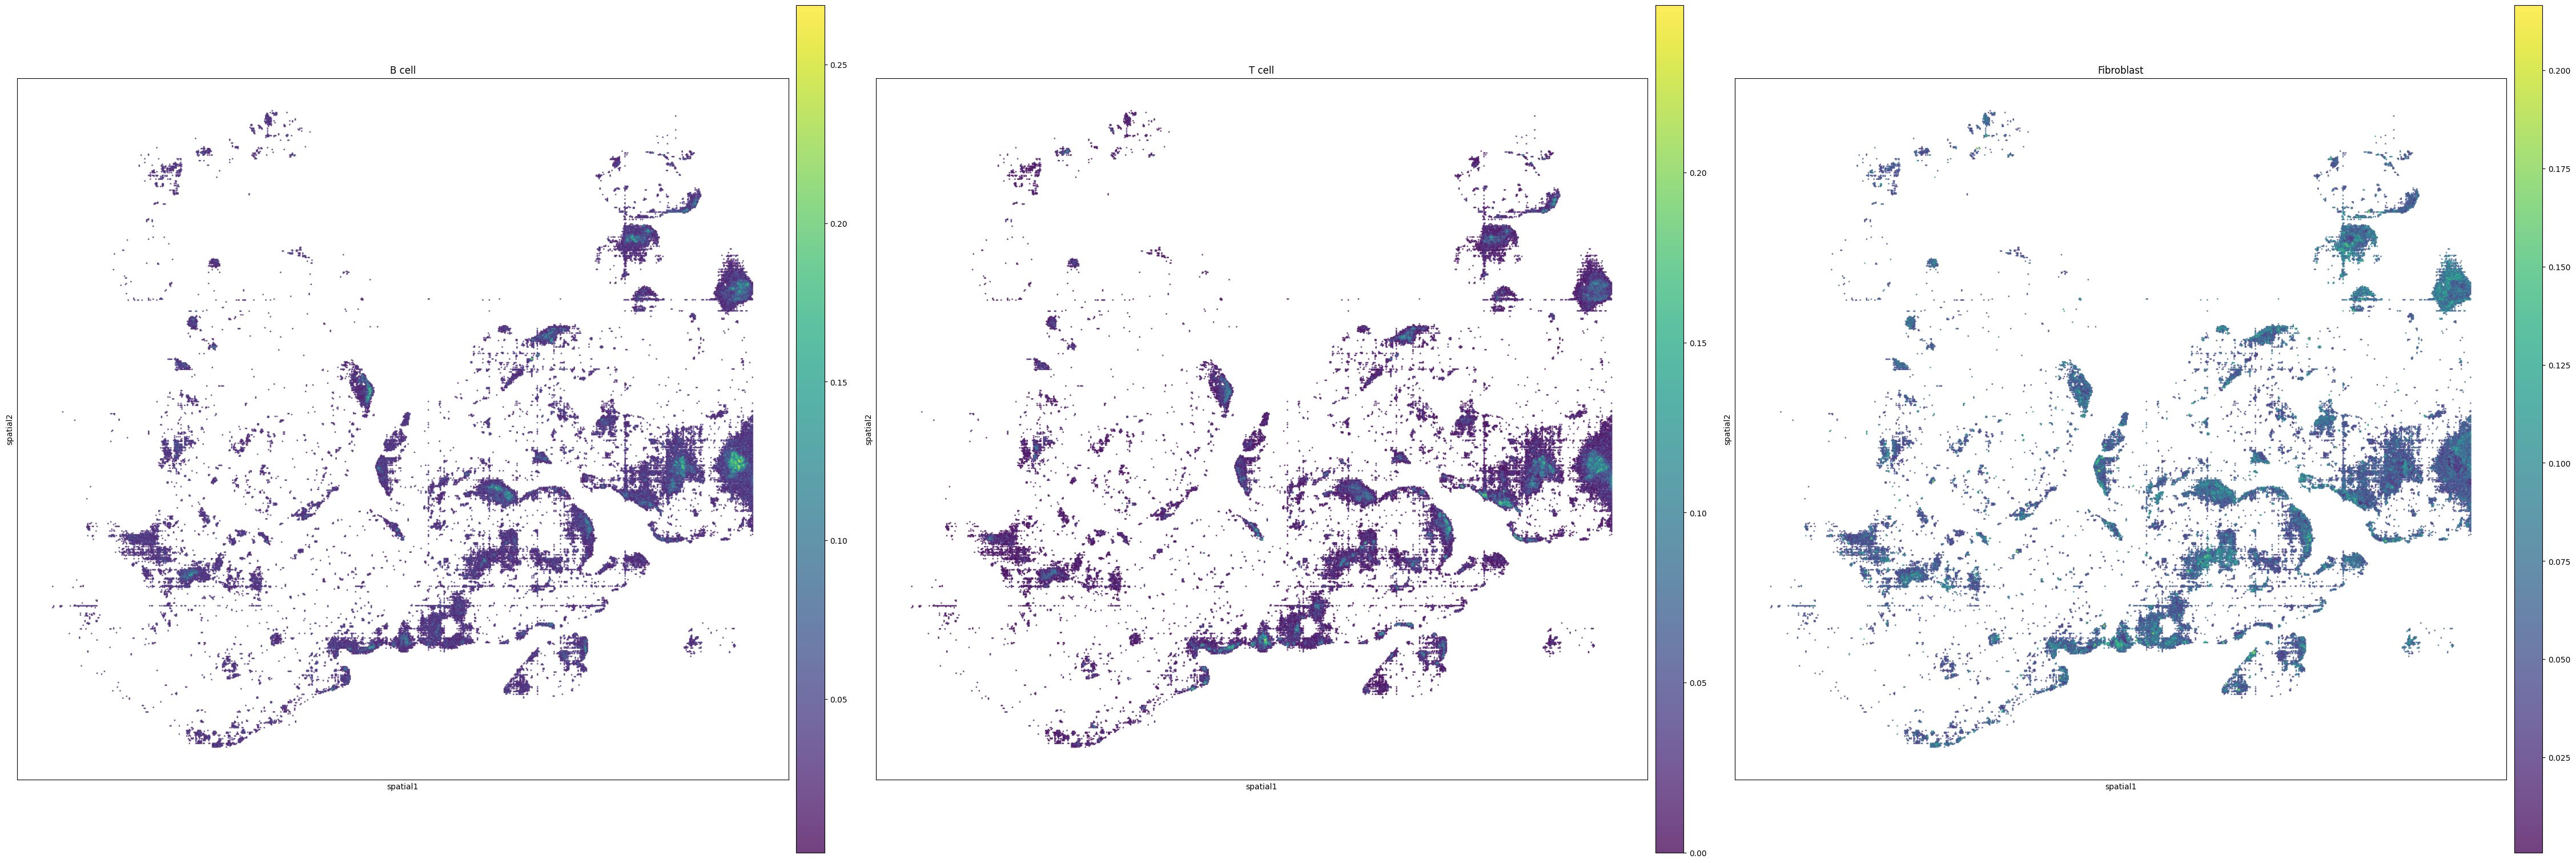

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(45, 15), layout="constrained")
sc.pl.spatial(
    aucell[aucell.obs["Identifier"] == samples[0]],
    color="B cell",
    spot_size=100,
    ax=ax[0],
    show=False,
    alpha=0.75,
)

sc.pl.spatial(
    aucell[aucell.obs["Identifier"] == samples[0]],
    color="T cell",
    spot_size=100,
    ax=ax[1],
    show=False,
    alpha=0.75,
)

sc.pl.spatial(
    aucell[aucell.obs["Identifier"] == samples[0]],
    color="Fibroblast",
    spot_size=100,
    ax=ax[2],
    show=False,
    alpha=0.75,
)

### Save/Load ALL

In [ ]:
# SAVE
annotation = "raw_processed-V5 WT_filter70.h5ad"
adata_sp.write(
    os.path.join(DATADIR, "processed", "combined", annotation)
)

In [ ]:
# SAVE
annotation = "raw_processed-V5 WT_filter70 AUCELL.h5ad"
aucell.write(os.path.join(DATADIR, "processed", "combined", annotation))

# Test Space

### Tangram

In [ ]:
import tangram as tg
annotation = "manDoublet-seuratV3-harmony-annotated"
adata_sc = sc.read_h5ad(
    os.path.join(
        DATADIR, "processed", "single cell", "3_annotated", f"{annotation}.h5ad"
    )
)
clear_uns(adata_sc, "colors")
adata_sc

AnnData object with n_obs × n_vars = 52143 × 21205
    obs: 'Identifier', 'Groups', 'Experiment', 'Condition', 'Sample Type', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'predicted_doublet-scDblFinder', 'doublet_score-scDblFinder', 'predicted_doublet-DoubletFinder', 'doublet_score-DoubletFinder', 'predicted_doublet-doubletdetection', 'doublet_score-doubletdetection', 'predicted_doublet-scrublet', 'doublet_score-scrublet', 'leiden_doublets', 'manual_doublet', 'leiden', 'cell_type'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'de_all', 'dendrogram_cell_type', 'hvg', 'leiden', 'log1p', 'methods', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'LocalMAP', 'MSigDB-M2-CP_padj_ulm', 'MSigDB-M2-CP_score_ulm', 'MSigDB-M3_padj_ulm', 'MSigDB-M3_score_ulm', 'MSigDB-M5-GO_padj_

In [18]:
markers = list(set.intersection(set(adata_sc.var_names), set(adata_sp.var_names)))
len(markers)

12586

In [ ]:
ad_map = tg.map_cells_to_space(adata_sc, adata_sp, mode='clusters', cluster_label='cell_type')
